In [1]:
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.algorithms.ppo.torch.ppo_torch_rl_module import PPOTorchRLModule
from ray.rllib.algorithms.ppo.ppo_catalog import PPOCatalog
from ray.rllib.core.rl_module.rl_module import SingleAgentRLModuleSpec
from ray.rllib.core.rl_module.torch.torch_rl_module import TorchCompileConfig
from ray.rllib.models.catalog import MODEL_DEFAULTS
from ray.rllib.core.learner.learner import FrameworkHyperparameters, LearnerHyperparameters
from ray.rllib.core.learner.scaling_config import LearnerGroupScalingConfig
from ray.rllib.core.testing.utils import get_module_spec
from ray.rllib.algorithms.ppo.torch.ppo_torch_learner import PPOTorchLearner
from ray.rllib.utils.test_utils import check
from ray.rllib.algorithms.ppo.ppo import PPOConfig
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
from ray.rllib.utils.torch_utils import convert_to_torch_tensor
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
import pandas as pd
import gymnasium as gym
import torch
import seaborn as sns 
import torch._dynamo as dynamo

sns.set_style("darkgrid")

In [11]:
torch._dynamo.allow_in_graph(torch.distributions.kl.kl_divergence)
torch._dynamo.disallow_in_graph(torch.distributions.kl.kl_divergence)
torch.set_float32_matmul_precision('high')

In [3]:
import time

In [4]:
# Some choices on what/how to test:
# Signifies batch size in evaluation
BATCH_SIZES_EVAL = [1, 8, 32, 64, 128]
# Signifies batch size in training
BATCH_SIZES_TRAIN = [8, 16, 32, 128, 512, 1024]
# Signifies how many iterations of evaluation/training we do to caluclate medians/means
N_ITERS_EVAL = 600
N_ITERS_TRAIN = 300

In [5]:
def get_ppo_batch_for_env(env: Union[str, gym.Env], batch_size):
    """Create a dummy sample batch for the given environment.
    
    Args:
        env: The environment to create a sample batch for. If a string is given,
        it is assumed to be a gym environment ID.
        batch_size: The batch size to use.

    Returns:
        A sample batch for the given environment.
    """
    env.reset()
    action = env.action_space.sample()
    if type(env.action_space) is gym.spaces.Box:
        action_inputs = [0.5, 0.5]
    else:
        action_inputs = [0.5]
    obs, reward, truncated, terminated, info = env.step(action)

    def batchify(x):
        x = np.array(x)
        return np.repeat(x[np.newaxis], batch_size, axis=0)

    # Fake CartPole episode of n time steps.
    return SampleBatch({
        SampleBatch.OBS: batchify(obs),
        SampleBatch.NEXT_OBS: batchify(obs),
        SampleBatch.ACTIONS: batchify([action]),
        SampleBatch.PREV_ACTIONS: batchify([action]),
        SampleBatch.REWARDS: batchify([reward]),
        SampleBatch.PREV_REWARDS: batchify([reward]),
        SampleBatch.TERMINATEDS: batchify([terminated]),
        SampleBatch.TRUNCATEDS: batchify([truncated]),
        SampleBatch.VF_PREDS: batchify(.0),
        SampleBatch.ACTION_DIST_INPUTS: batchify(action_inputs),
        SampleBatch.ACTION_LOGP: batchify(.0),
        SampleBatch.EPS_ID: batchify(0),
        "advantages": batchify(.0),
        "value_targets": batchify(.0),
        SampleBatch.AGENT_INDEX: batchify(0),
    })


def timed(fn, no_grad=True):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    if no_grad:
        with torch.no_grad():
            result = fn()
    else:
        result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000

In [6]:
# Setup for evaluation
env = wrap_deepmind(gym.make("GymV26Environment-v0", env_id="ALE/Breakout-v5"))
# env = gym.make("CartPole-v1")

model_cfg = MODEL_DEFAULTS.copy()

spec = SingleAgentRLModuleSpec(
    module_class=PPOTorchRLModule,
    observation_space=env.observation_space,
    action_space=env.action_space,
    catalog_class=PPOCatalog,
    model_config_dict=model_cfg
)

eager_module = spec.build().to(0)
compiled_module = spec.build().to(0)

compile_config = TorchCompileConfig()

# Compile only one of the modules.
compiled_module = compiled_module.compile(compile_config)

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
2023-06-14 15:17:03,917	WARNING deprecation.py:50 -- DeprecationWarning: `FrameStack` has been deprecated. This will raise an error in the future!


Troughput of eager = 724.1201070621051, compiled = 670.3383972657801, speed up = %-7.4271808325455515
(eval batch size 1) eager median: 0.0007772480249404908, compile median: 0.0009176959991455078, speedup median: 0.8469558826280249x
(eval batch size 1) eager mean: 0.0007910119459033012, compile mean: 0.0009192094934980074, speedup mean: 0.8605350048041208x


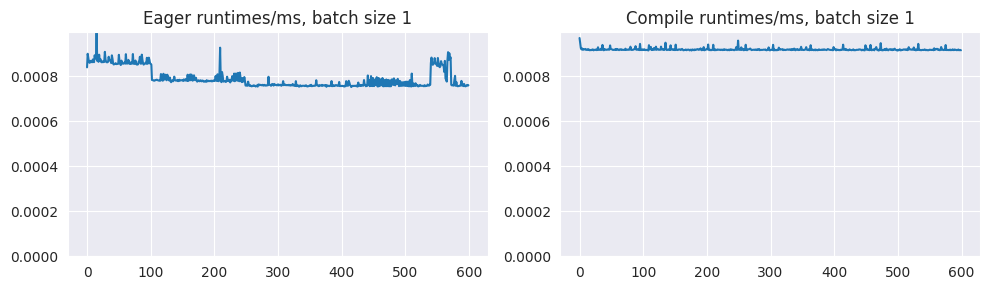

~~~~~~~~~~
Troughput of eager = 450.0071884349883, compiled = 413.26334005360343, speed up = %-8.165169207445487
(eval batch size 8) eager median: 0.0009953280091285705, compile median: 0.0012001279592514038, speedup median: 0.8293515716019314x
(eval batch size 8) eager mean: 0.0010130910393595695, compile mean: 0.0012018526351451875, speedup mean: 0.8429411474703676x


<Figure size 640x480 with 0 Axes>

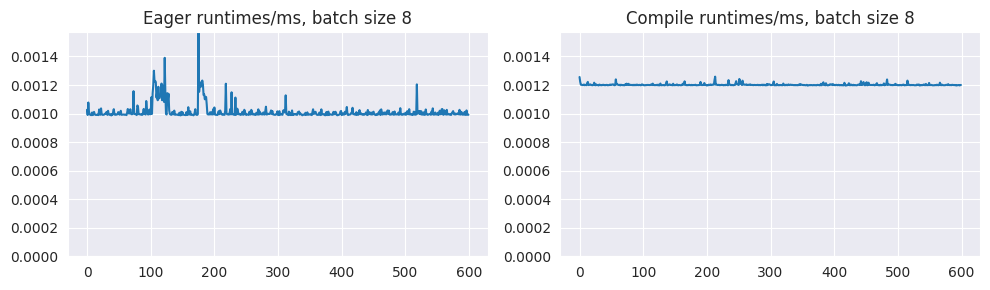

~~~~~~~~~~
Troughput of eager = 209.81204574344775, compiled = 195.64568308116353, speed up = %-6.7519300963332
(eval batch size 32) eager median: 0.0023388639688491824, compile median: 0.0026827679872512816, speedup median: 0.8718100036841213x
(eval batch size 32) eager mean: 0.002341686137119929, compile mean: 0.0026852821882565815, speedup mean: 0.8720447137216025x


<Figure size 640x480 with 0 Axes>

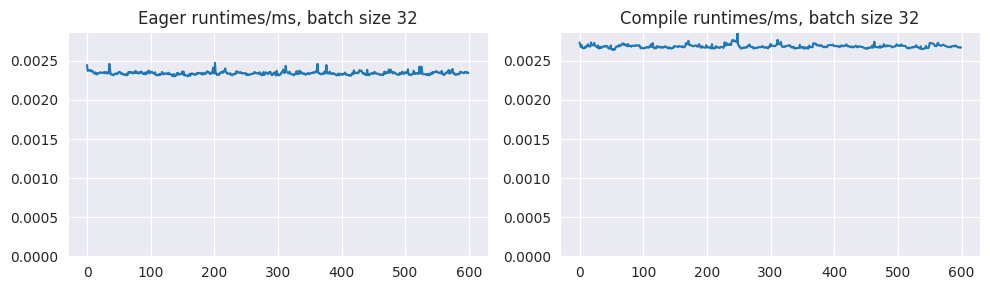

~~~~~~~~~~
Troughput of eager = 140.72707184260648, compiled = 132.65635911570524, speed up = %-5.7350107702999535
(eval batch size 64) eager median: 0.0028407200574874876, compile median: 0.0032526400089263915, speedup median: 0.8733582719549503x
(eval batch size 64) eager mean: 0.0028401149336496987, compile mean: 0.003251964164574941, speedup mean: 0.873353699462099x


<Figure size 640x480 with 0 Axes>

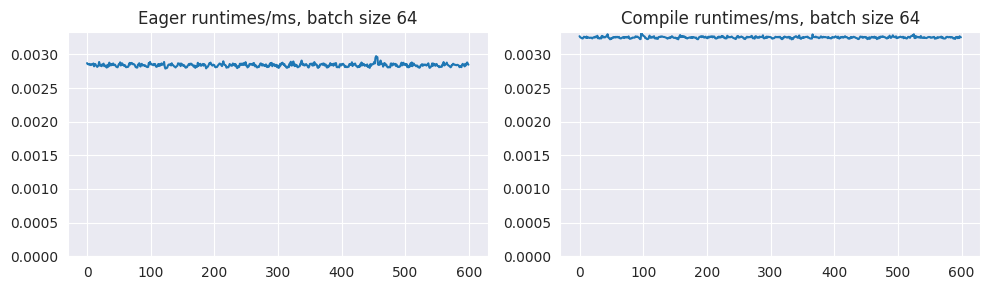

~~~~~~~~~~
Troughput of eager = 73.37246169916719, compiled = 71.74032773067273, speed up = %-2.2244503328596688
(eval batch size 128) eager median: 0.005065104007720947, compile median: 0.005540575981140137, speedup median: 0.9141836561690203x
(eval batch size 128) eager mean: 0.005064766658941905, compile mean: 0.005540675579706827, speedup mean: 0.914106337048865x


<Figure size 640x480 with 0 Axes>

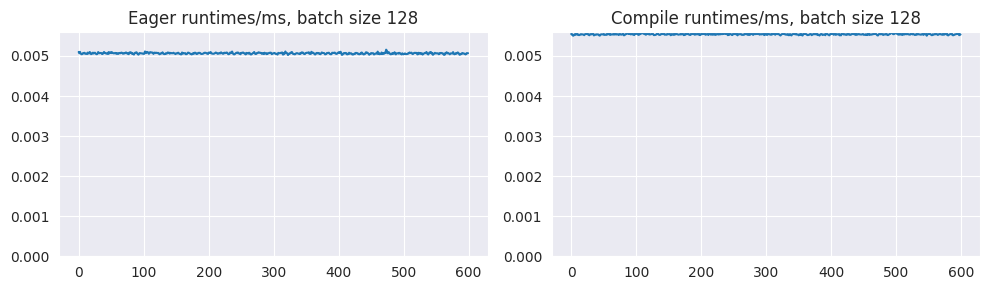

~~~~~~~~~~


<Figure size 640x480 with 0 Axes>

In [12]:
# The actual benchmark for evaluation

# Evaluation
def evaluate(mod, inp):
    return mod.forward_exploration(inp)

# Generates random input and targets data for the model, where `b` is
# batch size.
def generate_data(eval_batch):
    return {n: torch.Tensor(t).to(torch.float32).to(0) for n, t in eval_batch.items()}

def generate_target():
    return torch.Tensor(np.array([[-1.0, 2.5], [-1.0, -2.3], [-1, 2.5]])).to(torch.float32).to(0)

batchsizes_vs_speedups = []

eager_times = []
compile_times = []
speed_up_pecs = []
for batch_size in BATCH_SIZES_EVAL:
    eager_times = []
    compile_times = []
    eval_batch = get_ppo_batch_for_env(env, batch_size=batch_size)
    
    # Warm up for two steps (heuristically determined, to not have to use logarithmic scale for graphs below)
    for i in range(100):
        with torch.no_grad():
            inp = generate_data(eval_batch)
            evaluate(eager_module, inp)
            inp = generate_data(eval_batch)
            evaluate(compiled_module, inp)

    s_eager = time.time()
    for i in range(N_ITERS_EVAL):
        inp = generate_data(eval_batch)
        _, eager_time = timed(lambda: evaluate(eager_module, inp))
        eager_times.append(eager_time)
        # print(f"eager eval time {i}: {eager_time}")
    e_eager = time.time()
    
    s_compile = time.time()
    for i in range(N_ITERS_EVAL):
        inp = generate_data(eval_batch)
        _, compile_time = timed(lambda: evaluate(compiled_module, inp))
        compile_times.append(compile_time)
        # print(f"compile eval time {i}: {compile_time}")
    e_compile = time.time()

    eager_throughput = N_ITERS_EVAL / (e_eager - s_eager)
    compiled_thoughtput = N_ITERS_EVAL / (e_compile - s_compile)
    speed_up_perc = (compiled_thoughtput - eager_throughput) / eager_throughput * 100 # can also be negative
    speed_up_pecs.append(speed_up_perc)
    print(f"Troughput of eager = {eager_throughput}, compiled = {compiled_thoughtput}, speed up = %{speed_up_perc}")
    eager_med = np.median(eager_times)
    eager_mean = np.mean(eager_times)
    compile_med = np.median(compile_times)
    compile_mean = np.mean(compile_times)
    speedup_median = eager_med / compile_med
    speedup_mean = eager_mean / compile_mean
    print(f"(eval batch size {batch_size}) eager median: {eager_med}, compile median: {compile_med}, speedup median: {speedup_median}x")
    print(f"(eval batch size {batch_size}) eager mean: {eager_mean}, compile mean: {compile_mean}, speedup mean: {speedup_mean}x")
    
    batchsizes_vs_speedups.append([batch_size, speedup_median])
    
    upper_limit = max(np.concatenate([eager_times, compile_times]))
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    axes[0].plot(eager_times)
    axes[0].set_title(f'Eager runtimes/ms, batch size {batch_size}')
    axes[0].set_ylim(0, upper_limit)
    axes[1].plot(compile_times)
    axes[1].set_title(f'Compile runtimes/ms, batch size {batch_size}')
    axes[1].set_ylim(0, upper_limit)
    fig.tight_layout()
    plt.show()
    plt.clf()
    print("~" * 10)


<BarContainer object of 5 artists>

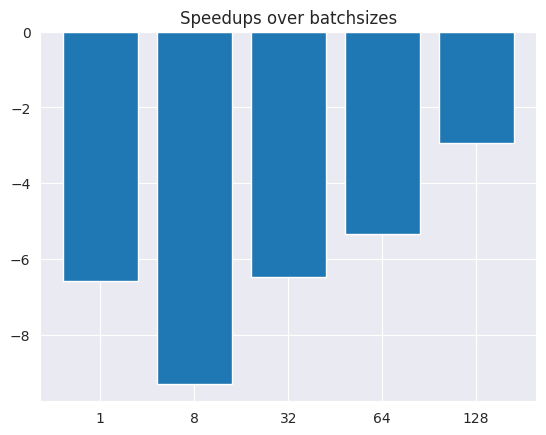

In [10]:

plt.title("Speedups over batchsizes")
plt.bar(list(map(str, BATCH_SIZES_EVAL)), speed_up_pecs)

In [ ]:
# Setup for training

framework_hps_eager = FrameworkHyperparameters(
    torch_compile=False,
    torch_compile_cfg=TorchCompileConfig(),
)
framework_hps_compile_update = FrameworkHyperparameters(
    torch_compile=True,
    what_to_compile="gradient_computation",
    torch_compile_cfg=TorchCompileConfig(
        torch_dynamo_backend="inductor",
        torch_dynamo_mode="max-autotune"
    ),
)
framework_hps_compile_forward_train = FrameworkHyperparameters(
    torch_compile=True,
    what_to_compile="forward_train",
    torch_compile_cfg=TorchCompileConfig(
        torch_dynamo_backend="inductor",
        torch_dynamo_mode="max-autotune"
    ),
)

ppo_config = PPOConfig()
learner_hps = ppo_config.get_learner_hyperparameters()
scaling_config = LearnerGroupScalingConfig(num_gpus_per_worker=1)
learner_eager = PPOTorchLearner(
    learner_hyperparameters=learner_hps,
    module_spec=spec,
    framework_hyperparameters=framework_hps_eager,
    learner_group_scaling_config=scaling_config,
)
learner_update_compiled = PPOTorchLearner(
    learner_hyperparameters=learner_hps,
    module_spec=spec,
    framework_hyperparameters=framework_hps_compile_update,
    learner_group_scaling_config=scaling_config,
)
learner_forward_train_compiled = PPOTorchLearner(
    learner_hyperparameters=learner_hps,
    module_spec=spec,
    framework_hyperparameters=framework_hps_compile_forward_train,
    learner_group_scaling_config=scaling_config,
)
learner_eager.build()
learner_update_compiled.build()
learner_forward_train_compiled.build()

[2023-06-14 14:54:05,301] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode


torch compile Learner speedups:
(train batch size 8) eager median: 0.030764559745788574
(train batch size 8) eager mean: 0.03076756845474243
(train batch size 8) update compile median: 0.029817904472351074, speedup median: 1.03174788068408x
(train batch size 8) update compile mean: 0.030036151917775474, speedup mean: 1.024351206471762x
(train batch size 8) forward compile median: 0.030320896148681643, speedup median: 1.0146322719134482x
(train batch size 8) forward compile mean: 0.03032077492396037, speedup mean: 1.014735557778538x


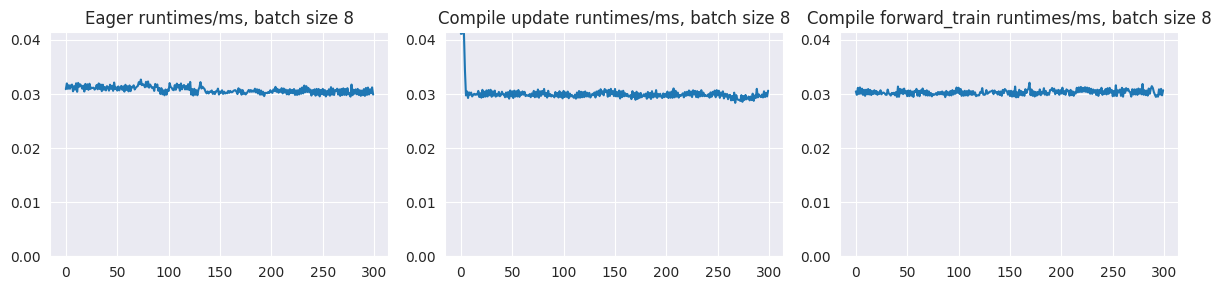

~~~~~~~~~~
torch compile Learner speedups:
(train batch size 16) eager median: 0.030246848106384276
(train batch size 16) eager mean: 0.030313047300974533
(train batch size 16) update compile median: 0.028593711853027344, speedup median: 1.057814678340962x
(train batch size 16) update compile mean: 0.028687261339823404, speedup mean: 1.0566727489910035x
(train batch size 16) forward compile median: 0.029919360160827635, speedup median: 1.0109456867993256x
(train batch size 16) forward compile mean: 0.030013586298624682, speedup mean: 1.009977514828462x


<Figure size 640x480 with 0 Axes>

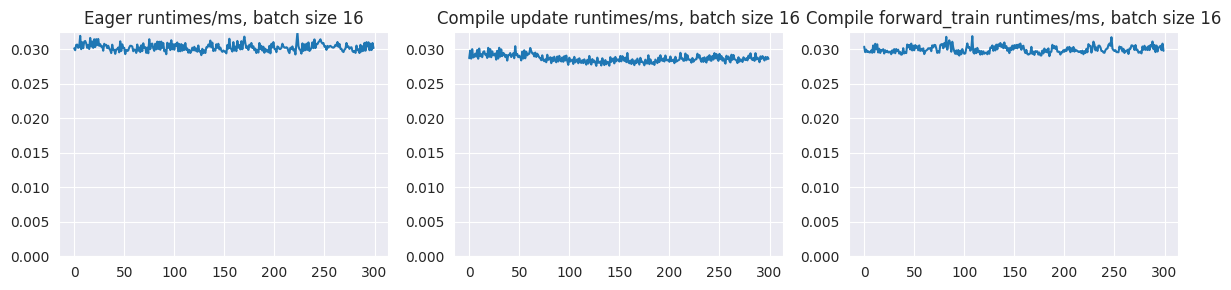

~~~~~~~~~~
torch compile Learner speedups:
(train batch size 32) eager median: 0.030548319816589356
(train batch size 32) eager mean: 0.030613686294555666
(train batch size 32) update compile median: 0.02890249538421631, speedup median: 1.0569440254377425x
(train batch size 32) update compile mean: 0.02900792501449585, speedup mean: 1.0553559511498112x
(train batch size 32) forward compile median: 0.030463760375976562, speedup median: 1.0027757387653127x
(train batch size 32) forward compile mean: 0.03051049257914225, speedup mean: 1.0033822369516237x


<Figure size 640x480 with 0 Axes>

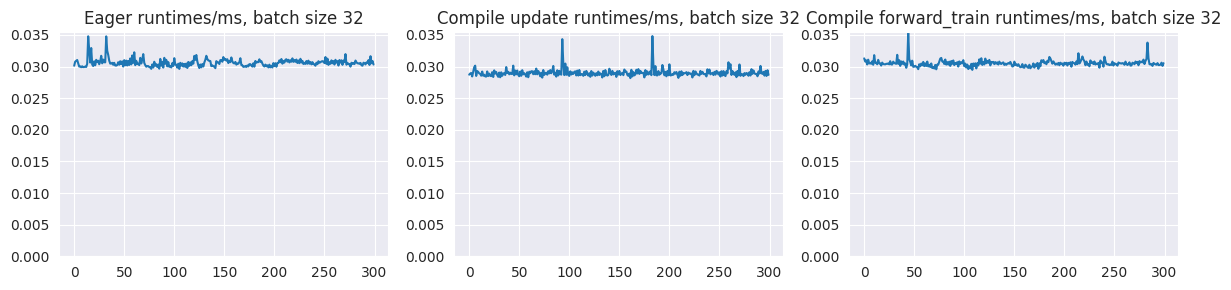

~~~~~~~~~~
torch compile Learner speedups:
(train batch size 128) eager median: 0.030515504837036134
(train batch size 128) eager mean: 0.03052845893224081
(train batch size 128) update compile median: 0.02894812774658203, speedup median: 1.0541443337605545x
(train batch size 128) update compile mean: 0.02896694871266683, speedup mean: 1.053906617333539x
(train batch size 128) forward compile median: 0.030408512115478514, speedup median: 1.0035185122228707x
(train batch size 128) forward compile mean: 0.03046032084782918, speedup mean: 1.0022369457220108x


<Figure size 640x480 with 0 Axes>

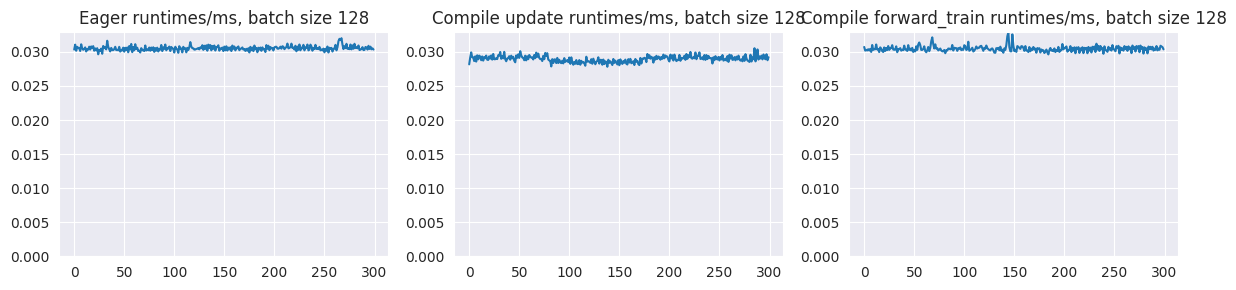

~~~~~~~~~~
torch compile Learner speedups:
(train batch size 512) eager median: 0.030267104148864746
(train batch size 512) eager mean: 0.030219583924611406
(train batch size 512) update compile median: 0.029043648719787596, speedup median: 1.0421247151444717x
(train batch size 512) update compile mean: 0.02908464003245036, speedup mean: 1.0390221055132456x
(train batch size 512) forward compile median: 0.030388592720031738, speedup median: 0.9960021652767451x
(train batch size 512) forward compile mean: 0.030407227185567223, speedup mean: 0.9938289913838352x


<Figure size 640x480 with 0 Axes>

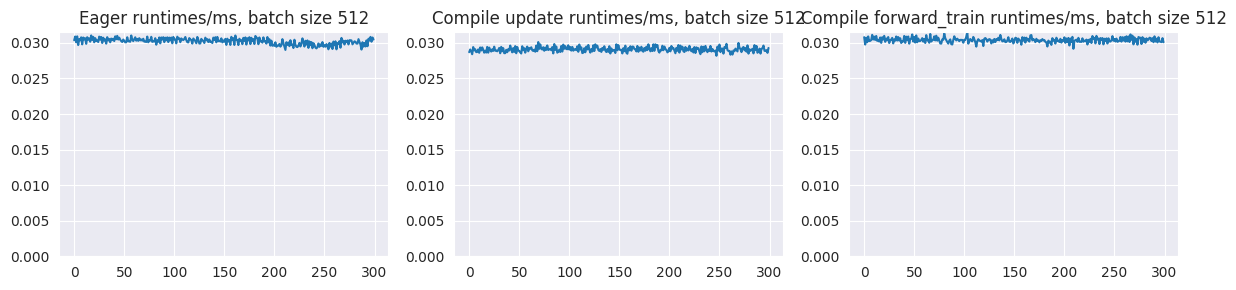

~~~~~~~~~~


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# Actual benchmark for training

train_batch = get_ppo_batch_for_env(env, batch_size=128)
batch = train_batch.as_multi_agent()
del compile_times

batchsizes_vs_speedups_update = []
batchsizes_vs_speedups_forward_train = []

for batch_size in BATCH_SIZES_TRAIN:

    eager_times = []
    update_compiled_times = []
    forward_train_compiled_times = []
    
    # Warm up for two steps (heuristically determined, to not have to use logarithmic scale for graphs below)
    for i in range(2):
        learner_update_compiled.update(batch)
        learner_eager.update(batch)
        learner_forward_train_compiled.update(batch)

    for i in range(N_ITERS_TRAIN):
        _, compile_time = timed(lambda: learner_update_compiled.update(batch), no_grad=False)
        update_compiled_times.append(compile_time)

    for i in range(N_ITERS_TRAIN):
        _, eager_time = timed(lambda: learner_eager.update(batch), no_grad=False)
        eager_times.append(eager_time)

    for i in range(N_ITERS_TRAIN):
        _, compile_time = timed(lambda: learner_forward_train_compiled.update(batch), no_grad=False)
        forward_train_compiled_times.append(compile_time)

    eager_med = np.median(eager_times)
    eager_mean = np.mean(eager_times)

    print("torch compile Learner speedups:")
    print(f"(train batch size {batch_size}) eager median: {eager_med}")
    print(f"(train batch size {batch_size}) eager mean: {eager_mean}")

    update_compiled_med = np.median(update_compiled_times)
    update_compiled_mean = np.mean(update_compiled_times)
    update_compiled_speedup_median = eager_med / update_compiled_med
    update_compiled_speedup_mean = eager_mean / update_compiled_mean
    print(f"(train batch size {batch_size}) update compile median: {update_compiled_med}, speedup median: {update_compiled_speedup_median}x")
    print(f"(train batch size {batch_size}) update compile mean: {update_compiled_mean}, speedup mean: {update_compiled_speedup_mean}x")

    forward_train_compiled_med = np.median(forward_train_compiled_times)
    forward_train_compiled_mean = np.mean(forward_train_compiled_times)
    forward_train_compiled_speedup_median = eager_med / forward_train_compiled_med
    forward_train_compiled_speedup_mean = eager_mean / forward_train_compiled_mean
    print(f"(train batch size {batch_size}) forward compile median: {forward_train_compiled_med}, speedup median: {forward_train_compiled_speedup_median}x")
    print(f"(train batch size {batch_size}) forward compile mean: {forward_train_compiled_mean}, speedup mean: {forward_train_compiled_speedup_mean}x")
    
    batchsizes_vs_speedups_update.append([batch_size, update_compiled_speedup_median])
    batchsizes_vs_speedups_forward_train.append([batch_size, forward_train_compiled_speedup_mean])
    
    upper_limit = max(np.concatenate([eager_times, update_compiled_times, forward_train_compiled_times]))
        
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    axes[0].plot(eager_times)
    axes[0].set_title(f'Eager runtimes/ms, batch size {batch_size}')
    axes[0].set_ylim(0, upper_limit)
    axes[1].plot(update_compiled_times)
    axes[1].set_title(f'Compile update runtimes/ms, batch size {batch_size}')
    axes[1].set_ylim(0, upper_limit)
    axes[2].plot(forward_train_compiled_times)
    axes[2].set_title(f'Compile forward_train runtimes/ms, batch size {batch_size}')
    axes[2].set_ylim(0, upper_limit)
    fig.tight_layout()
    plt.show()
    plt.clf()
    
    print("~" * 10)

plt.title(f'Compile update seepdups, batch size {batch_size}')
plt.plot(*zip(*batchsizes_vs_speedups_update))
plt.show()
plt.title(f'Compile forward_train seepdups, batch size {batch_size}')
plt.plot(*zip(*batchsizes_vs_speedups_forward_train))
plt.show()




In [ ]:
# Torch explain everything to get an overview of graph breaks for the above benchmarks

print("~" * 10)

# Convert batch to dict of dicts (which normally haps under the hood inside Learner.update())
batch = learner_eager._convert_batch_type(batch)
batch = {pid: {k:v for k,v in b.items()} for pid, b in batch.items()}

print(f"Torch dynamo explain output to check if graphs hav any breaks:")
print(f"TorchLearner._uncompiled_compute_gradients:")

import torch._dynamo as dynamo

dynamo_explanation = dynamo.explain(
    learner_eager._uncompiled_compute_gradients, batch)

print(dynamo_explanation[5])

print("~" * 10)

print(f"TorchRLModule.forward_train:")

dynamo_explanation = dynamo.explain(
    learner_eager._module._rl_modules["default_policy"].forward_train, batch["default_policy"])

print(dynamo_explanation[5])

print("~" * 10)

print(f"TorchRLModule.forward_exploration:")

dynamo_explanation = dynamo.explain(
    learner_eager._module._rl_modules["default_policy"].forward_exploration, batch["default_policy"])

print(dynamo_explanation[5])

print("~" * 10)

~~~~~~~~~~
Torch dynamo explain output to check if graphs hav any breaks:
TorchLearner._uncompiled_compute_gradients:
Dynamo produced 3 graphs with 2 graph break and 16 ops
 Break reasons: 

1. call_function args: TensorVariable() UserDefinedObjectVariable(lazy_property) 
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/rllib/core/learner/torch/torch_learner.py", line 107, in _uncompiled_compute_gradients
    loss_per_module = self.compute_loss(fwd_out=fwd_out, batch=batch)
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/rllib/core/learner/learner.py", line 958, in compute_loss
    loss = self.compute_loss_for_module(
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/rllib/algorithms/ppo/torch/ppo_torch_learner.py", line 64, in compute_loss_for_module
    curr_action_dist.logp(batch[SampleBatch.ACTIONS])
  File "/home/ray/anaconda3/lib/python3.10/site-packages/ray/rllib/models/torch/torch_distributions.py", line 37, in logp
    return self._dist.log_